# Import necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm 
from torchvision.utils import draw_bounding_boxes

In [3]:
print(torch.__version__)
print(torchvision.__version__)

1.9.1
0.10.1


In [4]:

!pip install pycocotools
from pycocotools.coco import COCO

     |████████████████████████████████| 403 kB 12.1 MB/s            


In [5]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [6]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [7]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [8]:
dataset_path = "/aquarium-dataset/Aquarium Combined/"

In [9]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

This code just gets a list of classes

In [10]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [11]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

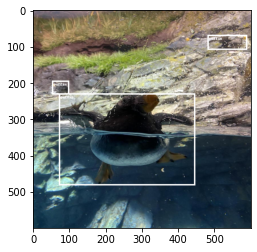

In [12]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [13]:
len(train_dataset)

447

## Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [14]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

The following blocks ensures that the model can take in the data and that it will not crash during training

In [17]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [18]:
device = torch.device("cuda") # use GPU to train

In [19]:
model = model.to(device)

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [20]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [21]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [22]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [23]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 112/112 [00:29<00:00,  3.79it/s]


Epoch 0, lr: 0.010000, loss: 1.010418, loss_classifier: 0.470842, loss_box: 0.403876, loss_rpn_box: 0.034305, loss_object: 0.101395


100%|██████████| 112/112 [00:21<00:00,  5.10it/s]


Epoch 1, lr: 0.010000, loss: 0.801879, loss_classifier: 0.372320, loss_box: 0.343428, loss_rpn_box: 0.028227, loss_object: 0.057904


100%|██████████| 112/112 [00:21<00:00,  5.13it/s]


Epoch 2, lr: 0.010000, loss: 0.733647, loss_classifier: 0.312136, loss_box: 0.345872, loss_rpn_box: 0.026835, loss_object: 0.048804


100%|██████████| 112/112 [00:22<00:00,  5.05it/s]


Epoch 3, lr: 0.010000, loss: 0.686089, loss_classifier: 0.280583, loss_box: 0.338986, loss_rpn_box: 0.025221, loss_object: 0.041299


100%|██████████| 112/112 [00:22<00:00,  4.94it/s]


Epoch 4, lr: 0.010000, loss: 0.656368, loss_classifier: 0.257119, loss_box: 0.335557, loss_rpn_box: 0.023887, loss_object: 0.039805


100%|██████████| 112/112 [00:22<00:00,  5.00it/s]


Epoch 5, lr: 0.010000, loss: 0.659472, loss_classifier: 0.255573, loss_box: 0.347572, loss_rpn_box: 0.023199, loss_object: 0.033128


100%|██████████| 112/112 [00:21<00:00,  5.14it/s]


Epoch 6, lr: 0.010000, loss: 0.656246, loss_classifier: 0.254039, loss_box: 0.347500, loss_rpn_box: 0.023669, loss_object: 0.031038


100%|██████████| 112/112 [00:21<00:00,  5.13it/s]


Epoch 7, lr: 0.010000, loss: 0.638259, loss_classifier: 0.240038, loss_box: 0.348537, loss_rpn_box: 0.021299, loss_object: 0.028386


100%|██████████| 112/112 [00:21<00:00,  5.19it/s]


Epoch 8, lr: 0.010000, loss: 0.613371, loss_classifier: 0.223213, loss_box: 0.345193, loss_rpn_box: 0.021088, loss_object: 0.023877


100%|██████████| 112/112 [00:21<00:00,  5.24it/s]

Epoch 9, lr: 0.010000, loss: 0.619963, loss_classifier: 0.226954, loss_box: 0.348695, loss_rpn_box: 0.020340, loss_object: 0.023973


## Trying on sample Images

In [24]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [25]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [26]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [27]:
# it did learn

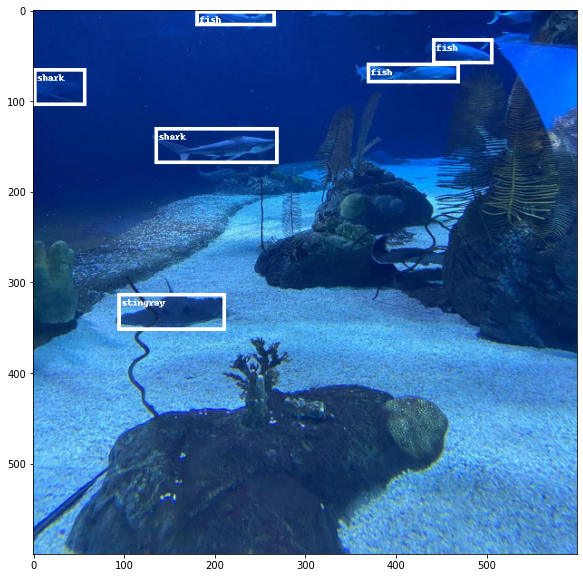

In [28]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

Project Report: Deep Learning Image Processing with PyTorch and COCO
Introduction
This project focuses on using deep learning techniques for image processing, particularly in object detection. The code leverages popular libraries like PyTorch, torchvision, and COCO tools to create, train, and evaluate a deep learning model.

Libraries and Tools
The project uses the following Python libraries:

Numpy and Pandas: For handling numerical data and data structures.
PyTorch and torchvision: The backbone of the deep learning framework, used to create models, manage datasets, and perform training.
PIL and OpenCV: Essential for image processing tasks like reading, modifying, and displaying images.
Albumentations: A powerful library for augmenting images, which helps improve model robustness by creating variations of the training data.
Matplotlib: For visualizing images and data plots.
TQDM: Provides a progress bar for loops, making it easier to track training progress.
COCO Tools
The COCO (Common Objects in Context) dataset format is commonly used in object detection tasks. The project installs and uses pycocotools, a library specifically designed to work with COCO annotations, to help with dataset management and evaluation.

Model Architecture
The code uses pre-trained models from torchvision, which are fine-tuned to adapt to the specific dataset used in the project. The models are built using the following steps:

Data Loading: Datasets are loaded using PyTorch's DataLoader, which handles batching and shuffling of data.
Transforms and Augmentations: Images are transformed and augmented to create a more varied and robust dataset for training.
Model Creation: A deep learning model, often a Convolutional Neural Network (CNN), is created or loaded as a pre-trained model.
Training and Evaluation: The model is trained using the training data and then evaluated on validation and test datasets to measure its performance.
Summary
This project provides a foundation for working with deep learning models in image processing tasks. By using powerful libraries and tools, it simplifies the process of loading datasets, augmenting images, creating models, and evaluating their performance.

The code structure and the use of libraries ensure that the model is both efficient and scalable, making it suitable for various image processing applications, especially in the field of object detection.

